In [ ]:
import numpy as np
import scipy.io.wavfile as wav
import numpy

files = [
    "audio/out_base.wav",
    "audio/out_hihat.wav",
    "audio/out_snare.wav",
]

files_float = []
for file in files:
    print(file)    
    srate, x = wav.read(file)
    files_float += [x]    

In [ ]:
import IPython.display as ipd

for i in range(len(files)):    
    ipd.display(files[i])
    print(len(files_float[i]))
    ipd.display(ipd.Audio(files_float[i], rate=44100))

In [51]:
import random
import wave
# from tqdm.notebook import tqdm

def generateRandom(sampleRate, fileLength):
    r = []
    s = 0
    
    while s + sampleRate < fileLength:
        file_id = random.randint(0, len(files_float)-1)
        loc = random.randint(0, sampleRate)
        s += loc
        if s + sampleRate < fileLength:
            r += [{'id': file_id, 'loc': loc}]
    
    return r

def generateMusic(locations, fileLength):
    output = numpy.zeros(fileLength, dtype=numpy.float);
    s = 0
    
    for item in locations:
        file = files_float[item['id']]
        s += item['loc']
        for l in range(len(file)):
            output[s + l] += file[l]
    return output

def writeWav(filePath, sampleRate, content):
    with wave.open(filePath,'wb') as f:
        f.setnchannels(1)
        f.setframerate(sampleRate)
        f.setnframes(len(content))
        f.setsampwidth(2)
        f.writeframes(content)
    
sampleRate = 44100
fileLength = sampleRate * 60
orders = []
generatedMusic = []
for j in tqdm(range(10)):
    r = generateRandom(sampleRate, fileLength)
    orders += [r]
    o = generateMusic(r, fileLength)
    generatedMusic += [o]
    ipd.display(ipd.Audio(o, rate=sampleRate))
    writeWav('audio/generated/generated_'+str(j)+'.wav', sampleRate, o) 


NameError: name 'tqdm' is not defined

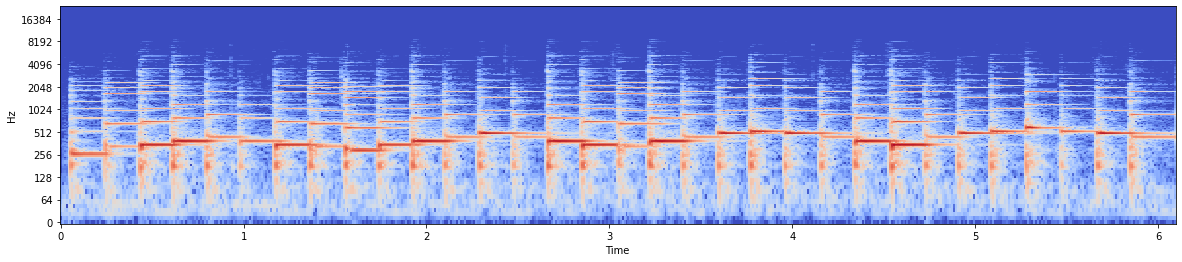

In [62]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from  scipy.io import wavfile

import numpy
sampleRate,x = wavfile.read('audio/piano.wav')
x = x/32767.0
S = librosa.stft(x, n_fft=4095)
S = numpy.abs(S)


# S = librosa.stft(generatedMusic[0])
plt.figure(figsize=[20,4])
logX = librosa.amplitude_to_db(S)
librosa.display.specshow(logX, sr=sampleRate, x_axis='time', y_axis='log')

In [64]:
n_components = 150
W, H = librosa.decompose.decompose(S, n_components=n_components, sort=True)
print(S.shape)
print(W.shape)
print(H.shape)
print(((W.shape[0] * W.shape[1])+ (H.shape[0] * H.shape[1])) / (S.shape[0] * S.shape[1]))

(2048, 572)
(2048, 150)
(150, 572)
0.33547994973776224


/home/matin/Git/UVic/DrumEncoder/venv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


/tmp/ipykernel_1298/2698528940.py:2: RuntimeWarning: divide by zero encountered in log10
  logW = numpy.log10(W)


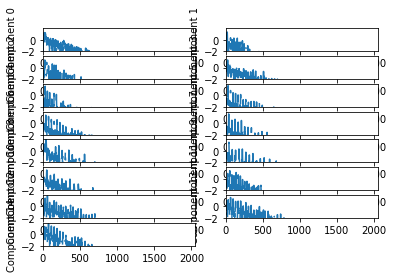

In [56]:
plt.figure()
logW = numpy.log10(W)
for n in range(n_components):
    plt.subplot(int(numpy.ceil(n_components/2.0)), 2, n+1)
    plt.plot(logW[:,n])
    plt.ylim(-2, logW.max())
    plt.xlim(0, W.shape[0])
    plt.ylabel('Component %d' % n)

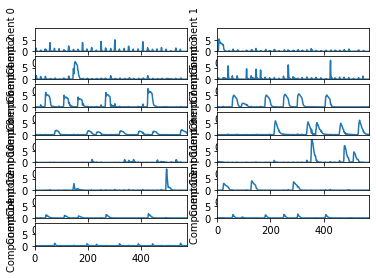

In [57]:
plt.figure()
for n in range(n_components):
    plt.subplot(int(numpy.ceil(n_components/2.0)), 2, n+1)
    plt.plot(H[n])
    plt.ylim(0, H.max())
    plt.xlim(0, H.shape[1])
    plt.ylabel('Component %d' % n)

In [65]:
from IPython.display import Audio

reconstructed_signal = numpy.zeros(len(x))
components = list()
for n in range(n_components):
    Y = numpy.outer(W[:,n], H[n])*numpy.exp(1j*numpy.angle(S))
    y = librosa.istft(Y)
    # components.append(y)
    reconstructed_signal[:len(y)] += y    
    # print('Component %d' % n)
    # display( Audio(y, rate=sampleRate) )
    
print('Reconstructed')
display( Audio(reconstructed_signal, rate=sampleRate) )

Reconstructed


In [66]:
x = numpy.array(reconstructed_signal * 32767, dtype='int16')
writeWav('reconstruct.wav', sampleRate, x)

In [ ]:
dy = numpy.subtract(generatedMusic[0],reconstructed_signal)
plt.plot(generatedMusic[0])
plt.plot(reconstructed_signal)
plt.plot(dy)
writeWav('audio/generated/generated_dy_0.wav', sampleRate, dy)
ipd.display(ipd.Audio(dy, rate=sampleRate))

In [ ]:
compressions = [
    {"name": "zip", "command": ["zip","-{level}","{output}","{input}"], "output": "file{level}.zip"},    
    {"name": "7z",  "command": ["7z","a","{output}","{input}","-mx={level}"], "output": "file.7z"},
    {"name": "flac","command": ["ffmpeg","-i","{input}","-c:a","flac",      "-compression_level","{level}","{output}"], "output": "file{level}.flac"},
    
    {"name": "vorbis","command": ["ffmpeg","-i","{input}","-c:a","libvorbis", "-b:a","{bitrate}k","{output}"], "output": "filevorbis{bitrate}.ogg"},
    {"name": "opus",  "command": ["ffmpeg","-i","{input}","-c:a","libopus",   "-b:a","{bitrate}k","{output}"], "output": "fileopus{bitrate}.ogg"},
    {"name": "mp3",   "command": ["ffmpeg","-i","{input}","-c:a","libmp3lame","-b:a","{bitrate}k","{output}"], "output": "file{bitrate}.mp3"},
    {"name": "aac",   "command": ["ffmpeg","-i","{input}","-c:a","aac",       "-b:a","{bitrate}k","{output}"], "output": "file{bitrate}.m4a"},    
]

import os
import subprocess
import datetime

def compress(input, compression):
    bitrate = 128
    level = 5
    output = compression['output'].format(level=level, bitrate=bitrate)
    command = compression['command'].copy()
    for i in range(len(command)):
        command[i] = command[i].format(input=input, output=output, bitrate=bitrate, level=level)
    
    with open("log.txt","a") as f:
        f.write(' '.join(command));
        f.write('\n')
    
        start = datetime.datetime.now()
        subprocess.run(command, stdout=f, stderr=f)    
        end = datetime.datetime.now()
    
    time = (end-start).total_seconds() * 1000    
    file_size = os.path.getsize(output)
    
    os.remove(output)
    
    return {"name": compression['name'], "level":level, "time": time, "size": file_size}

import sys

try:
    os.remove("log.txt")
except:
    pass

results = []
with tqdm(total=len(compressions)*1) as pbar:
#     for j in range(len(orders)):
        j = 0
        input = 'audio/generated/generated_'+str(j)+'.wav'
        initial_size = os.path.getsize(input)

        for c in compressions:    
            result = compress(input, c)
            result['ratio'] = result['size']*100/initial_size
            results += [result]           
            pbar.update(1)
            
import pandas

df = pandas.DataFrame.from_dict(results)
df = df.groupby('name').mean()


results = []
with tqdm(total=len(compressions)*1) as pbar:
    for c in compressions:    
        result = compress('audio/generated/generated_dy_0.wav', c)
        result['ratio'] = result['size']*100/initial_size
        results += [result]  
        pbar.update(1)
pandas.DataFrame.from_dict(results)

In [ ]:
# for index,row in df.iterrows():        
#     df.at[index,'size'] = row['size']/1024
df.plot.bar(y='size')
df

In [ ]:
with tqdm(total=len(compressions)*len(files)) as pbar:    
    results = []
    for c in compressions:         
        for j in range(len(files)):            
            input = files[j]
            initial_size = os.path.getsize(input)
           
            result = compress(input, c)  
            result['initial'] = initial_size;
            result['ratio'] = 0
            results += [result]           
            pbar.update(1)
            
df = pandas.DataFrame.from_dict(results)
df = df.groupby('name').sum()


In [ ]:
for index,row in df.iterrows():    
    df.at[index,'ratio'] = row['size']*100/row['initial']
    df.at[index,'size'] = row['size']/1024
df.plot.bar(y='size')
df